<a href="https://colab.research.google.com/github/jiya-0905/topsis-for-text-generation/blob/main/topsis_for_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Model Rankings:
          Model  TOPSIS Score
1  GPT-2-medium      0.596819
3       T5-base      0.571122
4    BLOOM-560m      0.552912
2     BART-base      0.468990
0   GPT-2-small      0.447088

Detailed Analysis Report:
          Model  TOPSIS Score  Perplexity  Generation_Speed  Model_Size_GB  \
1  GPT-2-medium      0.596819   -0.108108               0.2      -0.666667   
3       T5-base      0.571122   -0.324324               0.4      -0.333333   
4    BLOOM-560m      0.552912   -0.000000               0.0      -1.000000   
2     BART-base      0.468990   -0.594595               0.6      -0.200000   
0   GPT-2-small      0.447088   -1.000000               1.0      -0.000000   

   Memory_Usage_GB  BLEU_Score  
1             -0.8    0.942857  
3             -0.6    0.571429  
4             -1.0    1.000000  
2             -0.4    0.200000  
0             -0.0    0.000000  


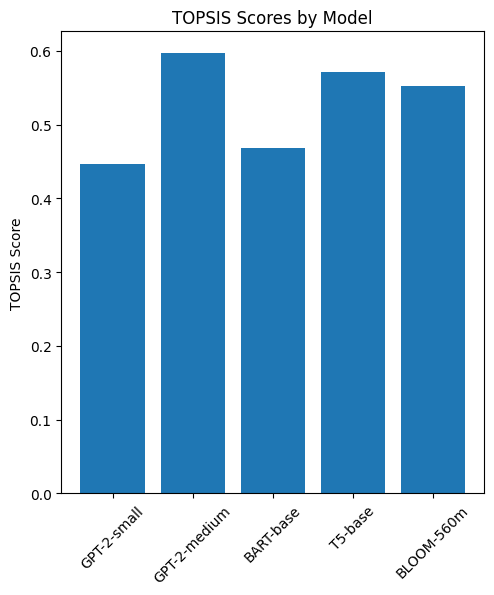

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go

class ModelEvaluator:
    def __init__(self):
        # Define the models and their characteristics
        self.models = [
            'GPT-2-small',
            'GPT-2-medium',
            'BART-base',
            'T5-base',
            'BLOOM-560m'
        ]

        # Define evaluation criteria
        self.criteria = [
            'Perplexity',        # Lower is better
            'Generation_Speed',   # Higher is better
            'Model_Size_GB',     # Lower is better
            'Memory_Usage_GB',    # Lower is better
            'BLEU_Score'         # Higher is better
        ]

        # Sample data
        self.decision_matrix = np.array([
            [15.5, 100, 0.5, 4, 32.5],    # GPT-2-small
            [12.2, 80, 1.5, 8, 35.8],     # GPT-2-medium
            [14.0, 90, 0.8, 6, 33.2],     # BART-base
            [13.0, 85, 1.0, 7, 34.5],     # T5-base
            [11.8, 75, 2.0, 9, 36.0]      # BLOOM-560m
        ])

        # Criteria weights (must sum to 1)
        self.weights = np.array([0.3, 0.2, 0.15, 0.15, 0.2])

        # Criteria type: 1 for benefit (higher better), -1 for cost (lower better)
        self.criteria_type = np.array([-1, 1, -1, -1, 1])

    def normalize_matrix(self):
        """Normalize the decision matrix"""
        scaler = MinMaxScaler()
        normalized = scaler.fit_transform(self.decision_matrix)
        # Adjust for criteria type (cost/benefit)
        normalized = normalized * self.criteria_type.reshape(1, -1)
        return normalized

    def calculate_topsis(self):
        """Calculate TOPSIS scores"""
        # Normalize the decision matrix
        normalized = self.normalize_matrix()

        # Weight the normalized matrix
        weighted = normalized * self.weights

        # Ideal best and worst solutions
        ideal_best = np.max(weighted, axis=0)
        ideal_worst = np.min(weighted, axis=0)

        # Calculate distances
        d_best = np.sqrt(np.sum((weighted - ideal_best)**2, axis=1))
        d_worst = np.sqrt(np.sum((weighted - ideal_worst)**2, axis=1))

        # Calculate relative closeness
        topsis_scores = d_worst / (d_worst + d_best)

        return topsis_scores

    def plot_results(self):
        """Create visualizations for the analysis"""
        scores = self.calculate_topsis()

        # 1. Bar plot of TOPSIS scores
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(self.models, scores)
        plt.title('TOPSIS Scores by Model')
        plt.xticks(rotation=45)
        plt.ylabel('TOPSIS Score')

        # 2. Radar chart of normalized criteria
        normalized = self.normalize_matrix()
        angles = np.linspace(0, 2*np.pi, len(self.criteria), endpoint=False)

        fig = go.Figure()
        for idx, model in enumerate(self.models):
            fig.add_trace(go.Scatterpolar(
                r=normalized[idx],
                theta=self.criteria,
                name=model
            ))

        fig.update_layout(
            polar=dict(radialaxis=dict(visible=True, range=[-1, 1])),
            showlegend=True,
            title='Model Comparison Across Criteria'
        )

        # 3. Create results DataFrame
        results_df = pd.DataFrame({
            'Model': self.models,
            'TOPSIS Score': scores
        })
        results_df = results_df.sort_values('TOPSIS Score', ascending=False)

        return fig, results_df

    def generate_report(self):
        """Generate a complete analysis report"""
        scores = self.calculate_topsis()
        normalized = self.normalize_matrix()

        report = pd.DataFrame({
            'Model': self.models,
            'TOPSIS Score': scores,
            **{criterion: normalized[:, i] for i, criterion in enumerate(self.criteria)}
        }).sort_values('TOPSIS Score', ascending=False)

        return report

def main():
    evaluator = ModelEvaluator()

    # Generate and display results
    radar_plot, results = evaluator.plot_results()
    full_report = evaluator.generate_report()

    print("\nModel Rankings:")
    print(results)

    print("\nDetailed Analysis Report:")
    print(full_report)

    # Save visualizations
    radar_plot.write_html("model_comparison_radar.html")
    plt.savefig("topsis_scores.png")

if __name__ == "__main__":
    main()